# `R` to `py` interoprability with [ryp](https://github.com/Wainberg/ryp)

`ryp` has much better (implicit) type conversion than `rpy2` and is much easier to use. It seems to make heavy use of `arrow` to move data between `R` and `py`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_friedman1

# interop package
import ryp

Loading required package: svglite


Create a numpy array

In [2]:
x = np.r_[-5:5:101j]
x[:10]

array([-5. , -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1])

### pass a python object into R

In [3]:
ryp.to_r(x, "x_np")

### run arbitrary R code

null device 
          1 


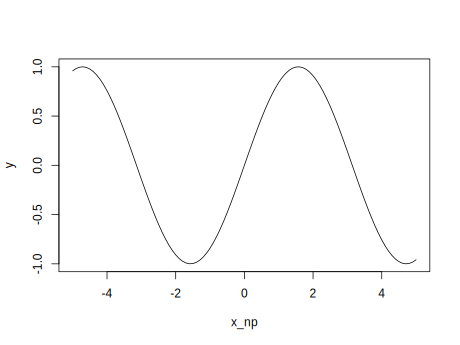

In [4]:
ryp.r(
    """
    y = sin(x_np)
    plot(x_np, y, type="l")
    """
)

Shows up fine in vscode, black box when rendered on github (for some reason - svgs are weird)

### Compute in R and return into python

In [6]:
fn = "cos"
ryp.r(
    f"""
      y = {fn}(x_np)
      """
)

In [7]:
y_r = ryp.to_py("y", format="numpy")
y_r[:5]

array([ 0.28366219,  0.18651237,  0.08749898, -0.01238866, -0.11215253])

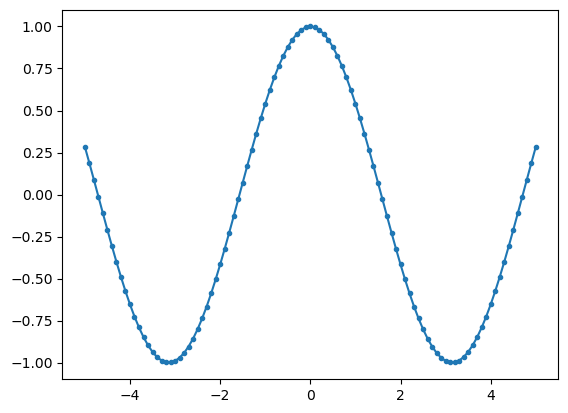

In [8]:
plt.plot(x, y_r, marker='.')

## An end-to-end example

### get some data in python, fit in `mgcv` in R, and return the results to python

The `friedman1` DGP has some smooth nonlinearity that a GAM can capture well.

In [9]:
X, y = make_friedman1(n_samples=1_000, n_features=5,
                      noise=0.5, random_state=42)

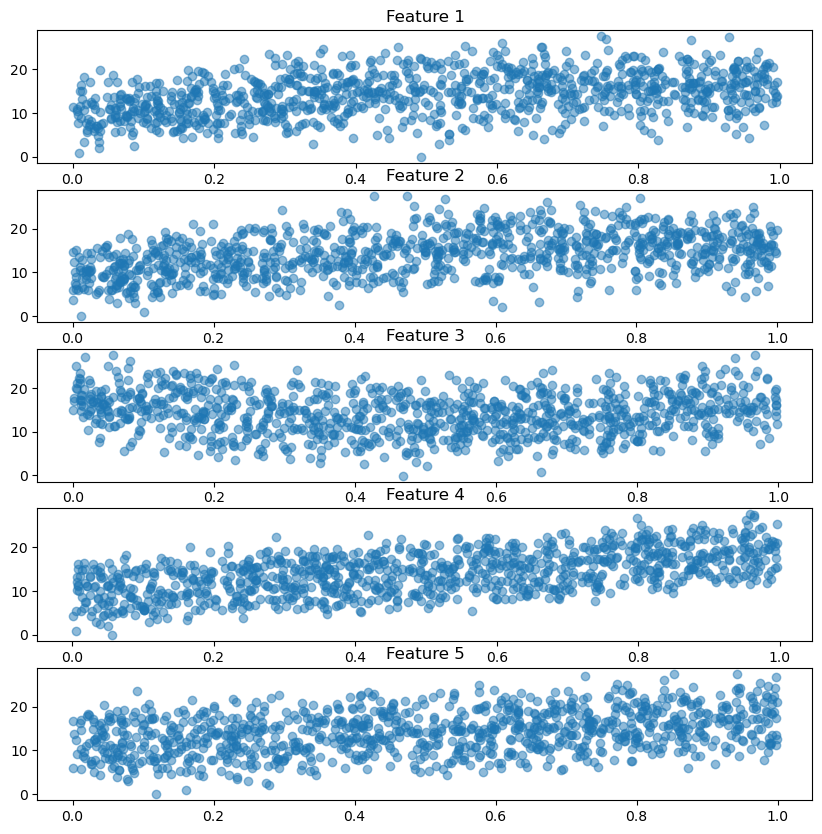

In [10]:
f, ax = plt.subplots(5, 1, figsize=(10, 10))
for i in range(5):
    ax[i].scatter(X[:, i], y, alpha=0.5)
    ax[i].set_title(f"Feature {i+1}")

Pass data to R

In [11]:
ryp.to_r(X, "X")
ryp.to_r(y, "y")

Fit `lm` and `gam` in R

In [12]:
r_code = """
library(mgcv)
model = gam(y ~ te(X[, 1], X[, 2]) + s(X[, 3]) + X[, 4] + X[, 5],
  )
summary(model)
"""
ryp.r(r_code)


Family: gaussian 
Link function: identity 

Formula:
y ~ te(X[, 1], X[, 2]) + s(X[, 3]) + X[, 4] + X[, 5]

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.7565     0.0412   164.0   <2e-16 ***
X[, 4]        9.9643     0.0557   179.0   <2e-16 ***
X[, 5]        4.9804     0.0560    88.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                    edf Ref.df    F p-value    
te(X[, 1],X[, 2]) 21.75  23.46 1902  <2e-16 ***
s(X[, 3])          6.53   7.67 1106  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.989   Deviance explained =   99%
GCV = 0.25657  Scale est. = 0.24854   n = 1000


In [13]:
lm_code = """
  linmod = lm(y ~ X)
  summary(linmod)
  """
ryp.r(lm_code)


Call:
lm(formula = y ~ X)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.241  -1.377   0.076   1.729   5.466 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.602      0.308    1.95   0.0510 .  
X1             6.662      0.267   24.93   <2e-16 ***
X2             6.763      0.261   25.92   <2e-16 ***
X3            -0.804      0.272   -2.96   0.0032 ** 
X4             9.312      0.271   34.39   <2e-16 ***
X5             5.349      0.269   19.90   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.45 on 994 degrees of freedom
Multiple R-squared:  0.746,	Adjusted R-squared:  0.745 
F-statistic:  583 on 5 and 994 DF,  p-value: <2e-16



Pass data back into python

In [14]:
yhat_gam = ryp.to_py("model$fitted.values", format="numpy")
yhat_lm = ryp.to_py("linmod$fitted.values", format="numpy")

Plot in python. 

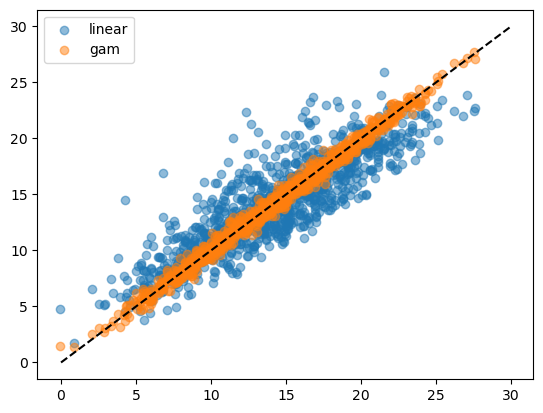

In [18]:
plt.scatter(y, yhat_lm, alpha=0.5, label="linear")
plt.scatter(y, yhat_gam, alpha=0.5, label="gam")
plt.plot([0, 30], [0, 30], 'k--')
plt.legend()

We see that the GAM is better calibrated (straddles the 45 degree line).